In [1]:
# Import needed files and basic setup
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

import data_gen2
import tropical

from ipywidgets import Output
from IPython.display import display, Markdown, Latex, Math, clear_output

from sklearn import neighbors

import math

from cvxopt import solvers, matrix

import time

import scipy

%matplotlib notebook
#plt.ion()

In [2]:
# Hyperparameters
n_epochs = 100
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 100

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [3]:
# Load training and testing sets
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [5]:
doTrain = True
if doTrain:
    network = Net()
    optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                          momentum=momentum)

In [6]:
if doTrain:
    train_losses = []
    train_acc = []
    train_counter = []
    test_losses = []
    test_acc = []
    test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [7]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            pred = output.data.max(1, keepdim=True)[1]
            correct = pred.eq(target.data.view_as(pred)).sum()
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {:.6f}'.format(
                  epoch, batch_idx * len(data), len(train_loader.dataset),
                  100. * batch_idx / len(train_loader), loss.item(), 100. * correct / 64))
            
            train_losses.append(loss.item())
            train_acc.append(100. * correct / 64)
            train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

In [8]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    test_acc.append(100. * correct / len(test_loader.dataset))
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
          test_loss, correct, len(test_loader.dataset),
          100. * correct / len(test_loader.dataset)))

In [9]:
if doTrain:
    test()
    for epoch in range(1, n_epochs + 1):
        train(epoch)
        test()

/home/ben/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/home/ben/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.2975, Accuracy: 1076/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.310654	Accuracy: 12.000000
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.771945	Accuracy: 78.000000
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.731136	Accuracy: 79.000000
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.426401	Accuracy: 92.000000
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.523612	Accuracy: 84.000000
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.433840	Accuracy: 85.000000
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.370254	Accuracy: 90.000000
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.326293	Accuracy: 89.000000
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.618390	Accuracy: 78.000000
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.193882	Accuracy: 93.000000

Test set: Avg. loss: 0.2697, Accuracy: 9248/10000 (92%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.572757	Accuracy: 81.000000
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.325578	Accuracy: 89.000000
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.477615	Accura

Train Epoch: 11 [57600/60000 (96%)]	Loss: 0.177759	Accuracy: 93.000000

Test set: Avg. loss: 0.1008, Accuracy: 9707/10000 (97%)

Train Epoch: 12 [0/60000 (0%)]	Loss: 0.104151	Accuracy: 98.000000
Train Epoch: 12 [6400/60000 (11%)]	Loss: 0.136064	Accuracy: 96.000000
Train Epoch: 12 [12800/60000 (21%)]	Loss: 0.146665	Accuracy: 96.000000
Train Epoch: 12 [19200/60000 (32%)]	Loss: 0.080061	Accuracy: 98.000000
Train Epoch: 12 [25600/60000 (43%)]	Loss: 0.086750	Accuracy: 98.000000
Train Epoch: 12 [32000/60000 (53%)]	Loss: 0.188842	Accuracy: 93.000000
Train Epoch: 12 [38400/60000 (64%)]	Loss: 0.096627	Accuracy: 98.000000
Train Epoch: 12 [44800/60000 (75%)]	Loss: 0.136195	Accuracy: 95.000000
Train Epoch: 12 [51200/60000 (85%)]	Loss: 0.170754	Accuracy: 92.000000
Train Epoch: 12 [57600/60000 (96%)]	Loss: 0.156850	Accuracy: 93.000000

Test set: Avg. loss: 0.0958, Accuracy: 9724/10000 (97%)

Train Epoch: 13 [0/60000 (0%)]	Loss: 0.218885	Accuracy: 92.000000
Train Epoch: 13 [6400/60000 (11%)]	Loss: 0.

Train Epoch: 22 [44800/60000 (75%)]	Loss: 0.153444	Accuracy: 95.000000
Train Epoch: 22 [51200/60000 (85%)]	Loss: 0.068552	Accuracy: 98.000000
Train Epoch: 22 [57600/60000 (96%)]	Loss: 0.188528	Accuracy: 92.000000

Test set: Avg. loss: 0.0812, Accuracy: 9754/10000 (97%)

Train Epoch: 23 [0/60000 (0%)]	Loss: 0.061629	Accuracy: 98.000000
Train Epoch: 23 [6400/60000 (11%)]	Loss: 0.075632	Accuracy: 98.000000
Train Epoch: 23 [12800/60000 (21%)]	Loss: 0.116948	Accuracy: 95.000000
Train Epoch: 23 [19200/60000 (32%)]	Loss: 0.058927	Accuracy: 98.000000
Train Epoch: 23 [25600/60000 (43%)]	Loss: 0.134872	Accuracy: 95.000000
Train Epoch: 23 [32000/60000 (53%)]	Loss: 0.081923	Accuracy: 98.000000
Train Epoch: 23 [38400/60000 (64%)]	Loss: 0.082914	Accuracy: 96.000000
Train Epoch: 23 [44800/60000 (75%)]	Loss: 0.094208	Accuracy: 95.000000
Train Epoch: 23 [51200/60000 (85%)]	Loss: 0.030484	Accuracy: 100.000000
Train Epoch: 23 [57600/60000 (96%)]	Loss: 0.170449	Accuracy: 96.000000

Test set: Avg. loss: 0.

Train Epoch: 33 [32000/60000 (53%)]	Loss: 0.066186	Accuracy: 98.000000
Train Epoch: 33 [38400/60000 (64%)]	Loss: 0.073896	Accuracy: 98.000000
Train Epoch: 33 [44800/60000 (75%)]	Loss: 0.053676	Accuracy: 100.000000
Train Epoch: 33 [51200/60000 (85%)]	Loss: 0.065175	Accuracy: 96.000000
Train Epoch: 33 [57600/60000 (96%)]	Loss: 0.115229	Accuracy: 96.000000

Test set: Avg. loss: 0.0746, Accuracy: 9771/10000 (97%)

Train Epoch: 34 [0/60000 (0%)]	Loss: 0.039592	Accuracy: 100.000000
Train Epoch: 34 [6400/60000 (11%)]	Loss: 0.098823	Accuracy: 96.000000
Train Epoch: 34 [12800/60000 (21%)]	Loss: 0.057599	Accuracy: 98.000000
Train Epoch: 34 [19200/60000 (32%)]	Loss: 0.062026	Accuracy: 100.000000
Train Epoch: 34 [25600/60000 (43%)]	Loss: 0.187241	Accuracy: 96.000000
Train Epoch: 34 [32000/60000 (53%)]	Loss: 0.056434	Accuracy: 100.000000
Train Epoch: 34 [38400/60000 (64%)]	Loss: 0.076765	Accuracy: 96.000000
Train Epoch: 34 [44800/60000 (75%)]	Loss: 0.063804	Accuracy: 98.000000
Train Epoch: 34 [5120

Train Epoch: 44 [19200/60000 (32%)]	Loss: 0.076631	Accuracy: 98.000000
Train Epoch: 44 [25600/60000 (43%)]	Loss: 0.079871	Accuracy: 98.000000
Train Epoch: 44 [32000/60000 (53%)]	Loss: 0.028862	Accuracy: 98.000000
Train Epoch: 44 [38400/60000 (64%)]	Loss: 0.045526	Accuracy: 100.000000
Train Epoch: 44 [44800/60000 (75%)]	Loss: 0.061844	Accuracy: 95.000000
Train Epoch: 44 [51200/60000 (85%)]	Loss: 0.089866	Accuracy: 96.000000
Train Epoch: 44 [57600/60000 (96%)]	Loss: 0.052673	Accuracy: 96.000000

Test set: Avg. loss: 0.0702, Accuracy: 9787/10000 (97%)

Train Epoch: 45 [0/60000 (0%)]	Loss: 0.030107	Accuracy: 100.000000
Train Epoch: 45 [6400/60000 (11%)]	Loss: 0.083792	Accuracy: 95.000000
Train Epoch: 45 [12800/60000 (21%)]	Loss: 0.042960	Accuracy: 100.000000
Train Epoch: 45 [19200/60000 (32%)]	Loss: 0.037579	Accuracy: 98.000000
Train Epoch: 45 [25600/60000 (43%)]	Loss: 0.042858	Accuracy: 100.000000
Train Epoch: 45 [32000/60000 (53%)]	Loss: 0.091171	Accuracy: 96.000000
Train Epoch: 45 [3840

Train Epoch: 55 [6400/60000 (11%)]	Loss: 0.055425	Accuracy: 98.000000
Train Epoch: 55 [12800/60000 (21%)]	Loss: 0.081483	Accuracy: 95.000000
Train Epoch: 55 [19200/60000 (32%)]	Loss: 0.067000	Accuracy: 96.000000
Train Epoch: 55 [25600/60000 (43%)]	Loss: 0.036501	Accuracy: 100.000000
Train Epoch: 55 [32000/60000 (53%)]	Loss: 0.175809	Accuracy: 96.000000
Train Epoch: 55 [38400/60000 (64%)]	Loss: 0.022391	Accuracy: 100.000000
Train Epoch: 55 [44800/60000 (75%)]	Loss: 0.037664	Accuracy: 98.000000
Train Epoch: 55 [51200/60000 (85%)]	Loss: 0.035258	Accuracy: 100.000000
Train Epoch: 55 [57600/60000 (96%)]	Loss: 0.034911	Accuracy: 100.000000

Test set: Avg. loss: 0.0681, Accuracy: 9793/10000 (97%)

Train Epoch: 56 [0/60000 (0%)]	Loss: 0.039600	Accuracy: 98.000000
Train Epoch: 56 [6400/60000 (11%)]	Loss: 0.072174	Accuracy: 98.000000
Train Epoch: 56 [12800/60000 (21%)]	Loss: 0.013031	Accuracy: 100.000000
Train Epoch: 56 [19200/60000 (32%)]	Loss: 0.132761	Accuracy: 96.000000
Train Epoch: 56 [2560

Train Epoch: 65 [57600/60000 (96%)]	Loss: 0.041095	Accuracy: 98.000000

Test set: Avg. loss: 0.0709, Accuracy: 9795/10000 (97%)

Train Epoch: 66 [0/60000 (0%)]	Loss: 0.121018	Accuracy: 96.000000
Train Epoch: 66 [6400/60000 (11%)]	Loss: 0.062508	Accuracy: 96.000000
Train Epoch: 66 [12800/60000 (21%)]	Loss: 0.010673	Accuracy: 100.000000
Train Epoch: 66 [19200/60000 (32%)]	Loss: 0.114893	Accuracy: 95.000000
Train Epoch: 66 [25600/60000 (43%)]	Loss: 0.175943	Accuracy: 95.000000
Train Epoch: 66 [32000/60000 (53%)]	Loss: 0.139325	Accuracy: 95.000000
Train Epoch: 66 [38400/60000 (64%)]	Loss: 0.098671	Accuracy: 96.000000
Train Epoch: 66 [44800/60000 (75%)]	Loss: 0.099710	Accuracy: 93.000000
Train Epoch: 66 [51200/60000 (85%)]	Loss: 0.109088	Accuracy: 96.000000
Train Epoch: 66 [57600/60000 (96%)]	Loss: 0.099122	Accuracy: 95.000000

Test set: Avg. loss: 0.0687, Accuracy: 9796/10000 (97%)

Train Epoch: 67 [0/60000 (0%)]	Loss: 0.062839	Accuracy: 98.000000
Train Epoch: 67 [6400/60000 (11%)]	Loss: 0

Train Epoch: 76 [44800/60000 (75%)]	Loss: 0.036990	Accuracy: 98.000000
Train Epoch: 76 [51200/60000 (85%)]	Loss: 0.072071	Accuracy: 98.000000
Train Epoch: 76 [57600/60000 (96%)]	Loss: 0.045099	Accuracy: 98.000000

Test set: Avg. loss: 0.0689, Accuracy: 9803/10000 (98%)

Train Epoch: 77 [0/60000 (0%)]	Loss: 0.119025	Accuracy: 93.000000
Train Epoch: 77 [6400/60000 (11%)]	Loss: 0.068063	Accuracy: 98.000000
Train Epoch: 77 [12800/60000 (21%)]	Loss: 0.037463	Accuracy: 96.000000
Train Epoch: 77 [19200/60000 (32%)]	Loss: 0.032665	Accuracy: 100.000000
Train Epoch: 77 [25600/60000 (43%)]	Loss: 0.068552	Accuracy: 96.000000
Train Epoch: 77 [32000/60000 (53%)]	Loss: 0.065541	Accuracy: 95.000000
Train Epoch: 77 [38400/60000 (64%)]	Loss: 0.108774	Accuracy: 96.000000
Train Epoch: 77 [44800/60000 (75%)]	Loss: 0.026707	Accuracy: 100.000000
Train Epoch: 77 [51200/60000 (85%)]	Loss: 0.056223	Accuracy: 98.000000
Train Epoch: 77 [57600/60000 (96%)]	Loss: 0.077628	Accuracy: 96.000000

Test set: Avg. loss: 0

Train Epoch: 87 [25600/60000 (43%)]	Loss: 0.118173	Accuracy: 96.000000
Train Epoch: 87 [32000/60000 (53%)]	Loss: 0.008041	Accuracy: 100.000000
Train Epoch: 87 [38400/60000 (64%)]	Loss: 0.107279	Accuracy: 96.000000
Train Epoch: 87 [44800/60000 (75%)]	Loss: 0.074532	Accuracy: 96.000000
Train Epoch: 87 [51200/60000 (85%)]	Loss: 0.051403	Accuracy: 98.000000
Train Epoch: 87 [57600/60000 (96%)]	Loss: 0.044505	Accuracy: 98.000000

Test set: Avg. loss: 0.0704, Accuracy: 9798/10000 (97%)

Train Epoch: 88 [0/60000 (0%)]	Loss: 0.084572	Accuracy: 98.000000
Train Epoch: 88 [6400/60000 (11%)]	Loss: 0.040746	Accuracy: 98.000000
Train Epoch: 88 [12800/60000 (21%)]	Loss: 0.029619	Accuracy: 98.000000
Train Epoch: 88 [19200/60000 (32%)]	Loss: 0.054108	Accuracy: 100.000000
Train Epoch: 88 [25600/60000 (43%)]	Loss: 0.018684	Accuracy: 100.000000
Train Epoch: 88 [32000/60000 (53%)]	Loss: 0.018132	Accuracy: 100.000000
Train Epoch: 88 [38400/60000 (64%)]	Loss: 0.055170	Accuracy: 100.000000
Train Epoch: 88 [448

Train Epoch: 98 [6400/60000 (11%)]	Loss: 0.047581	Accuracy: 96.000000
Train Epoch: 98 [12800/60000 (21%)]	Loss: 0.052253	Accuracy: 96.000000
Train Epoch: 98 [19200/60000 (32%)]	Loss: 0.064792	Accuracy: 96.000000
Train Epoch: 98 [25600/60000 (43%)]	Loss: 0.056298	Accuracy: 96.000000
Train Epoch: 98 [32000/60000 (53%)]	Loss: 0.068460	Accuracy: 98.000000
Train Epoch: 98 [38400/60000 (64%)]	Loss: 0.040691	Accuracy: 98.000000
Train Epoch: 98 [44800/60000 (75%)]	Loss: 0.140199	Accuracy: 98.000000
Train Epoch: 98 [51200/60000 (85%)]	Loss: 0.025951	Accuracy: 100.000000
Train Epoch: 98 [57600/60000 (96%)]	Loss: 0.018201	Accuracy: 100.000000

Test set: Avg. loss: 0.0688, Accuracy: 9800/10000 (98%)

Train Epoch: 99 [0/60000 (0%)]	Loss: 0.050179	Accuracy: 98.000000
Train Epoch: 99 [6400/60000 (11%)]	Loss: 0.018117	Accuracy: 100.000000
Train Epoch: 99 [12800/60000 (21%)]	Loss: 0.050609	Accuracy: 98.000000
Train Epoch: 99 [19200/60000 (32%)]	Loss: 0.010791	Accuracy: 100.000000
Train Epoch: 99 [25600

In [10]:
if doTrain:
    params = []
    for param in network.parameters():
        params.append(param.detach().numpy())

    A1 = params[0]
    b1 = params[1]
    A2 = params[2]
    b2 = params[3]

In [11]:
if doTrain:
    np.savez('parameters', A1=A1, b1=b1, A2=A2, b2=b2)

In [24]:
npzfile = np.load('parameters.npz')

A1 = npzfile['A1']
b1 = npzfile['b1']
A2 = npzfile['A2']
b2 = npzfile['b2']

In [14]:
# Get all the inputs and targets
inputs = np.zeros((0, 784))
targets = np.zeros((0, 1))
for batch_idx, (data, target) in enumerate(train_loader):
    x = data.view(-1, 28*28).numpy()
    y = target.numpy()
    
    inputs = np.vstack((inputs, x))
    targets = np.vstack([targets, y.reshape((-1, 1))])
    
# Create the KNN for the original datapoints
inputVector = neighbors.KNeighborsClassifier(3, weights='distance', p=2)
inputVector.fit(inputs, targets.ravel())

# Create the KNN for the feature vectors
features = np.matmul(inputs, A1.T) + b1
inputs = None
featureVector = neighbors.KNeighborsClassifier(3, weights='distance', p=2)
featureVector.fit(features, targets.ravel())

# Create the KNN for the binary vectors
featuresBinary = features > 0
features = None
binaryVector = neighbors.KNeighborsClassifier(3, weights='distance', metric='hamming')
binaryVector.fit(featuresBinary, targets.ravel())
featuresBinary = None

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='distance')

In [25]:
print(A2.shape)
print(A1.shape)

(1, 128)
(128, 784)


<IPython.core.display.Javascript object>


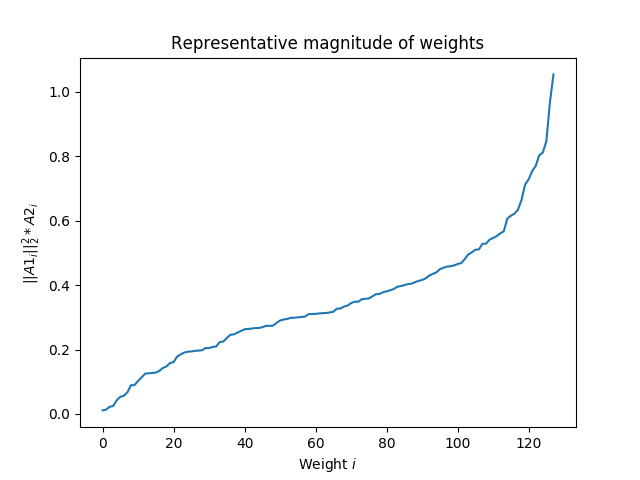

In [42]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(sorted(np.abs(np.multiply(A2, np.power(np.linalg.norm(A1, axis=1), 2))).T));
ax.set_title('Representative magnitude of weights')
ax.set_xlabel('Weight $i$')
ax.set_ylabel('$||A1_i||_2^2 * A2_i$');

In [17]:
# K nearest neighbors test
def test():
    vals = []
    for i in range(1, 11):
        start = time.time()
        # Get all the inputs and targets
        inputs = np.zeros((0, 784))
        targets = np.zeros((0, 1))
        for batch_idx, (data, target) in enumerate(train_loader):
            x = data.view(-1, 28*28).numpy()
            y = target.numpy()

            inputs = np.vstack((inputs, x))
            targets = np.vstack([targets, y.reshape((-1, 1))])

        # Create the KNN for the original datapoints
        inputVector = neighbors.KNeighborsClassifier(i, weights='distance', p=2)
        inputVector.fit(inputs, targets.ravel())

        # Create the KNN for the feature vectors
        features = np.matmul(inputs, A1.T) + b1
        inputs = None
        featureVector = neighbors.KNeighborsClassifier(i, weights='distance', p=2)
        featureVector.fit(features, targets.ravel())

        # Create the KNN for the binary vectors
        featuresBinary = features > 0
        features = None
        binaryVector = neighbors.KNeighborsClassifier(i, weights='distance', metric='hamming')
        binaryVector.fit(featuresBinary, targets.ravel())
        featuresBinary = None

        correctInput = 0
        correctFeature = 0
        correctBinary = 0

        timeInput = 0
        timeFeature = 0
        timeBinary = 0

        for data, target in test_loader:

            data = data.view(-1, 784).numpy()

            start = time.time()
            output1 = inputVector.predict(data)
            timeInput += time.time() - start

            data = np.matmul(data, A1.T) + b1
            start = time.time()
            output2 = featureVector.predict(data)
            timeFeature += time.time() - start

            start = time.time()
            data = data > 0
            output3 = binaryVector.predict(data)
            timeBinary += time.time() - start

            correctInput += np.sum(output1 == target.numpy())
            correctFeature += np.sum(output2 == target.numpy())
            correctBinary += np.sum(output3 == target.numpy())

        vals.append((correctInput, correctFeature, correctBinary))
        print(vals[-1], time.time() - start)
    return vals

In [18]:
vals = test()
# Original, feature representation, binary
# correct/time

(9691, 9757, 9746) 8.544295310974121
(9691, 9757, 9748) 8.81536078453064
(9717, 9767, 9747) 9.402190446853638
(9714, 9771, 9758) 9.48528504371643
(9691, 9757, 9758) 9.656675577163696
(9709, 9759, 9757) 9.344479084014893
(9700, 9748, 9751) 9.457987070083618
(9706, 9749, 9753) 9.763645887374878
(9673, 9740, 9751) 9.78117847442627
(9684, 9742, 9747) 9.717866659164429


<IPython.core.display.Javascript object>


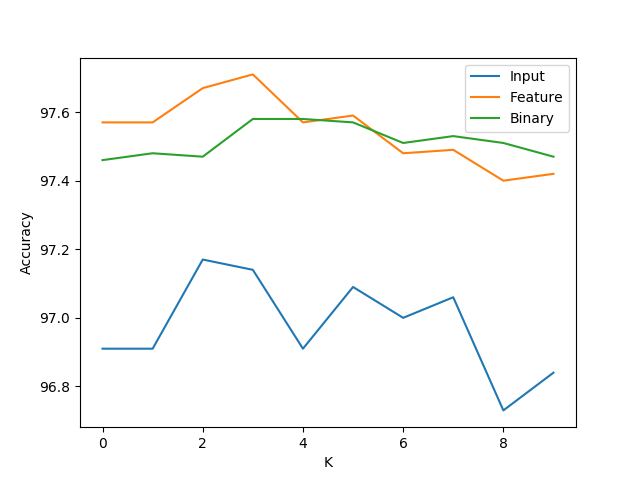

Text(0,0.5,'Accuracy')

In [19]:
original = [val[0]/100 for val in vals]
feature = [val[1]/100 for val in vals]
binary = [val[2]/100 for val in vals]

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(original, label='Input')
ax.plot(feature, label='Feature')
ax.plot(binary, label='Binary')
ax.legend()
ax.set_xlabel('K')
ax.set_ylabel('Accuracy')

In [ ]:
# Connected components test

In [8]:
# Get and save the feature for each sample
features = np.zeros((0, 128))
binaryFeatures = np.zeros((0, 128), dtype=np.bool)
targets = np.zeros((0, 1))

for batch_idx, (data, target) in enumerate(train_loader):
    x = data.view(-1, 28*28).numpy()
    y = target.numpy()
    
    feature = np.matmul(x, A1.T) + b1
    
    features = np.vstack((features, feature))
    binaryFeatures = np.vstack((binaryFeatures, feature > 0))
    targets = np.vstack([targets, y.reshape((-1, 1))])
    
np.savez('features', features=features, targets=targets)
np.savez('binaryFeatures', binaryFeatures=binaryFeatures, targets=targets)

In [9]:
features = None

In [4]:
npzfile = np.load('binaryFeatures.npz')

binaryFeatures = npzfile['binaryFeatures']
targets = npzfile['targets']

In [5]:
print(binaryFeatures.shape)

(60000, 128)


In [11]:
distances = None

In [14]:
binaryFeatures = binaryFeatures[targets.ravel() == 5, :]

In [15]:
print(binaryFeatures.shape)

(5421, 128)


In [8]:
def calcDistDistribution(features):
    # Distances
    distances = scipy.spatial.distance.squareform((scipy.spatial.distance.pdist(features, metric='hamming')*128).astype(np.uint8))
    
    # How many of each distance
    dists = []
    for i in range(129):
        if i == 0:
            #print(i, (np.sum(distances == i) - binaryFeatures.shape[0])/2)
            dists.append((np.sum(distances == i) - binaryFeatures.shape[0])//2)
        else:
            #print(i, np.sum(distances == i)/2)
            dists.append(np.sum(distances == i)//2)
            
    # How many connected components
    comps = []
    foundOne = 0
    for i in range(1, 128):
        tempDistances = np.copy(distances)
        tempDistances[tempDistances > i] = 0
        comps.append(scipy.sparse.csgraph.connected_components(tempDistances)[0])
        if comps[-1] == 1:
            foundOne = i
            break
    for i in range(foundOne, 128):
        comps.append(1)
        
    return distances, dists, comps

<IPython.core.display.Javascript object>


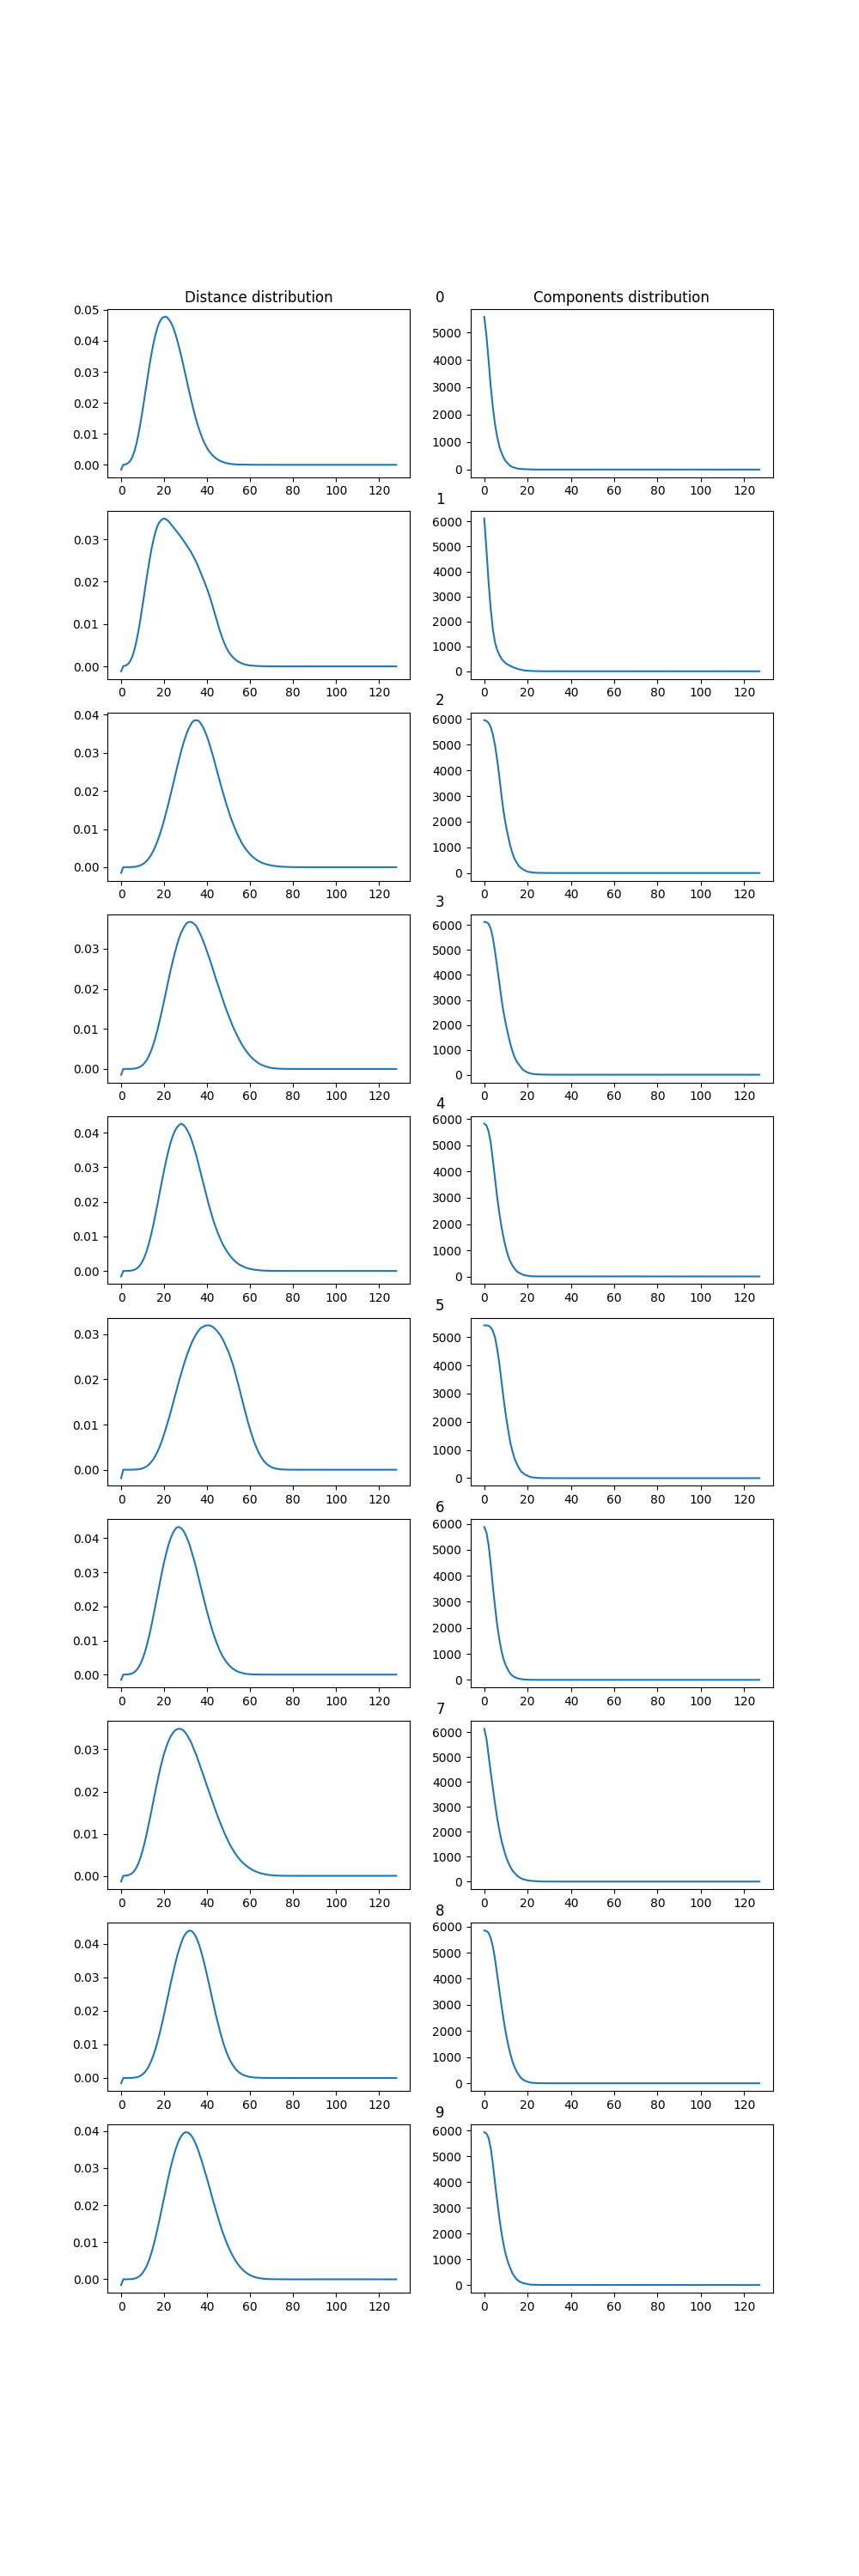

0:	 mean: 22.386270264671023	 median: 22.0	 max: 69	 min: 1
1:	 mean: 26.290450789496077	 median: 25.0	 max: 80	 min: 1
2:	 mean: 36.154774706373054	 median: 36.0	 max: 91	 min: 1
3:	 mean: 34.755386532835885	 median: 34.0	 max: 87	 min: 1
4:	 mean: 29.77592135524536	 median: 29.0	 max: 82	 min: 1
5:	 mean: 40.44144994761502	 median: 40.0	 max: 88	 min: 1
6:	 mean: 28.21706307025119	 median: 28.0	 max: 76	 min: 1
7:	 mean: 30.217072742895105	 median: 29.0	 max: 84	 min: 1
8:	 mean: 32.25725899079695	 median: 32.0	 max: 79	 min: 1
9:	 mean: 32.21811712098362	 median: 32.0	 max: 82	 min: 1


In [9]:
# Plot distributions
fig = plt.figure(figsize=(10, 30))
fig.tight_layout()

axFull = fig.add_subplot(1, 2, 1)
axFull.set_title('Distance distribution')
axFull.set_axis_off()
axFull = fig.add_subplot(1, 2, 2)
axFull.set_title('Components distribution')
axFull.set_axis_off()

for i in range(10):
    axFull = fig.add_subplot(10, 1, i+1)
    ax1 = fig.add_subplot(10, 2, i*2+1)
    ax2 = fig.add_subplot(10, 2, i*2+2)
    
    distances, dists, comps = calcDistDistribution(binaryFeatures[targets.ravel() == i, :])
    
    print("{}:\t mean: {}\t median: {}\t max: {}\t min: {}".format(i, np.mean(distances), np.median(distances), np.amax(distances), np.amin(distances[distances > 0])))
    
    ax1.plot(dists/sum(dists))
    ax2.plot(comps)
    axFull.set_title('{}'.format(i))
    axFull.set_axis_off()

In [10]:
distances = np.zeros((binaryFeatures.shape[0], binaryFeatures.shape[0]), dtype=np.uint8)

for i in range(binaryFeatures.shape[0]):
    for j in range(i, binaryFeatures.shape[0]):
        distances[i, j] = np.sum(np.logical_xor(binaryFeatures[i, :], binaryFeatures[j, :]))
        distances[j, i] = distances[i, j]

In [11]:
np.save('fullHammingDistances', distances)

In [6]:
distances = np.load('fullHammingDistances.npy')
print(distances.shape)

(60000, 60000)


In [12]:
print("{}:\t mean: {}\t median: {}\t max: {}\t min: {}".format(i, np.mean(distances), np.median(distances), np.amax(distances), np.amin(distances[distances > 0])))

59999:	 mean: 52.79831396944444	 median: 54.0	 max: 104	 min: 1


In [7]:
# Calc full distribution
dists = []
for i in range(129):
    if i == 0:
        #print(i, (np.sum(distances == i) - binaryFeatures.shape[0])/2)
        dists.append((np.sum(distances == i) - binaryFeatures.shape[0])//2)
    else:
        #print(i, np.sum(distances == i)/2)
        dists.append(np.sum(distances == i)//2)

# How many connected components
# comps = []
# foundOne = 0
# for i in range(1, 128):
#     tempDistances = np.copy(distances)
#     tempDistances[tempDistances > i] = 0
#     comps.append(scipy.sparse.csgraph.connected_components(tempDistances)[0])
#     if comps[-1] == 1:
#         foundOne = i
#         break
# for i in range(foundOne, 128):
#     comps.append(1)

<IPython.core.display.Javascript object>


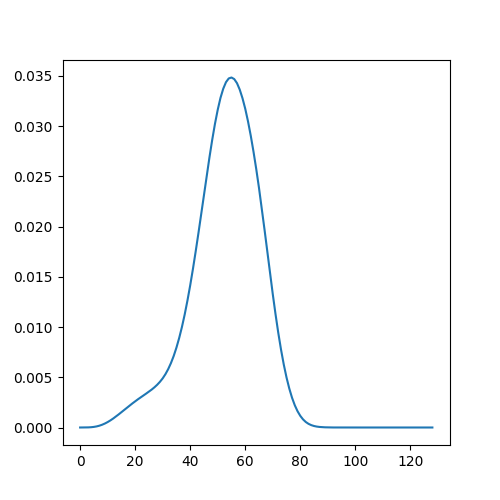

In [8]:
# Plot full distribution
fig = plt.figure(figsize=(5, 5))
ax1 = fig.add_subplot(1, 1, 1)

#print("{}:\t mean: {}\t median: {}\t max: {}\t min: {}".format(i, np.mean(distances), np.median(distances), np.amax(distances), np.amin(distances[distances > 0])))

ax1.plot(dists/np.sum(dists))
#ax2.plot(comps)

<IPython.core.display.Javascript object>


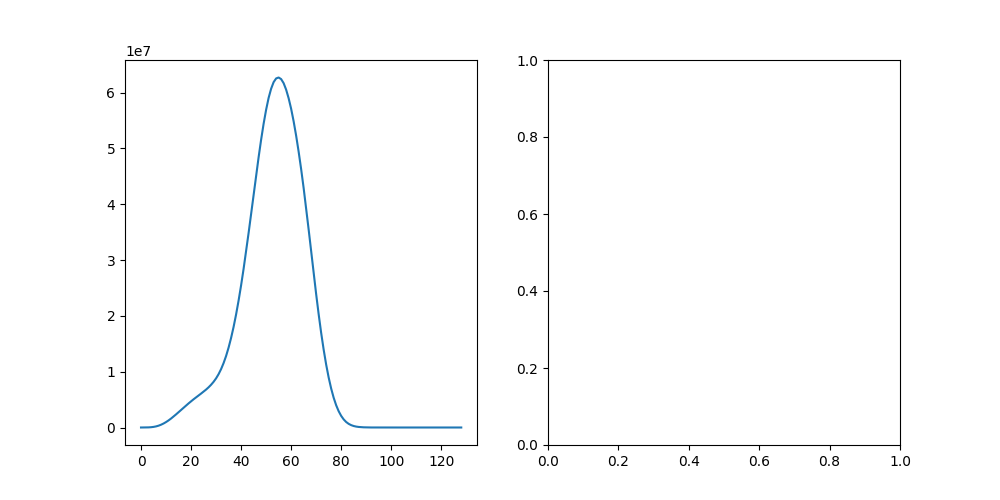

In [15]:
# Plot full distribution
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

#print("{}:\t mean: {}\t median: {}\t max: {}\t min: {}".format(i, np.mean(distances), np.median(distances), np.amax(distances), np.amin(distances[distances > 0])))

ax1.plot(dists/np.sum(dists))
#ax2.plot(comps)

<IPython.core.display.Javascript object>


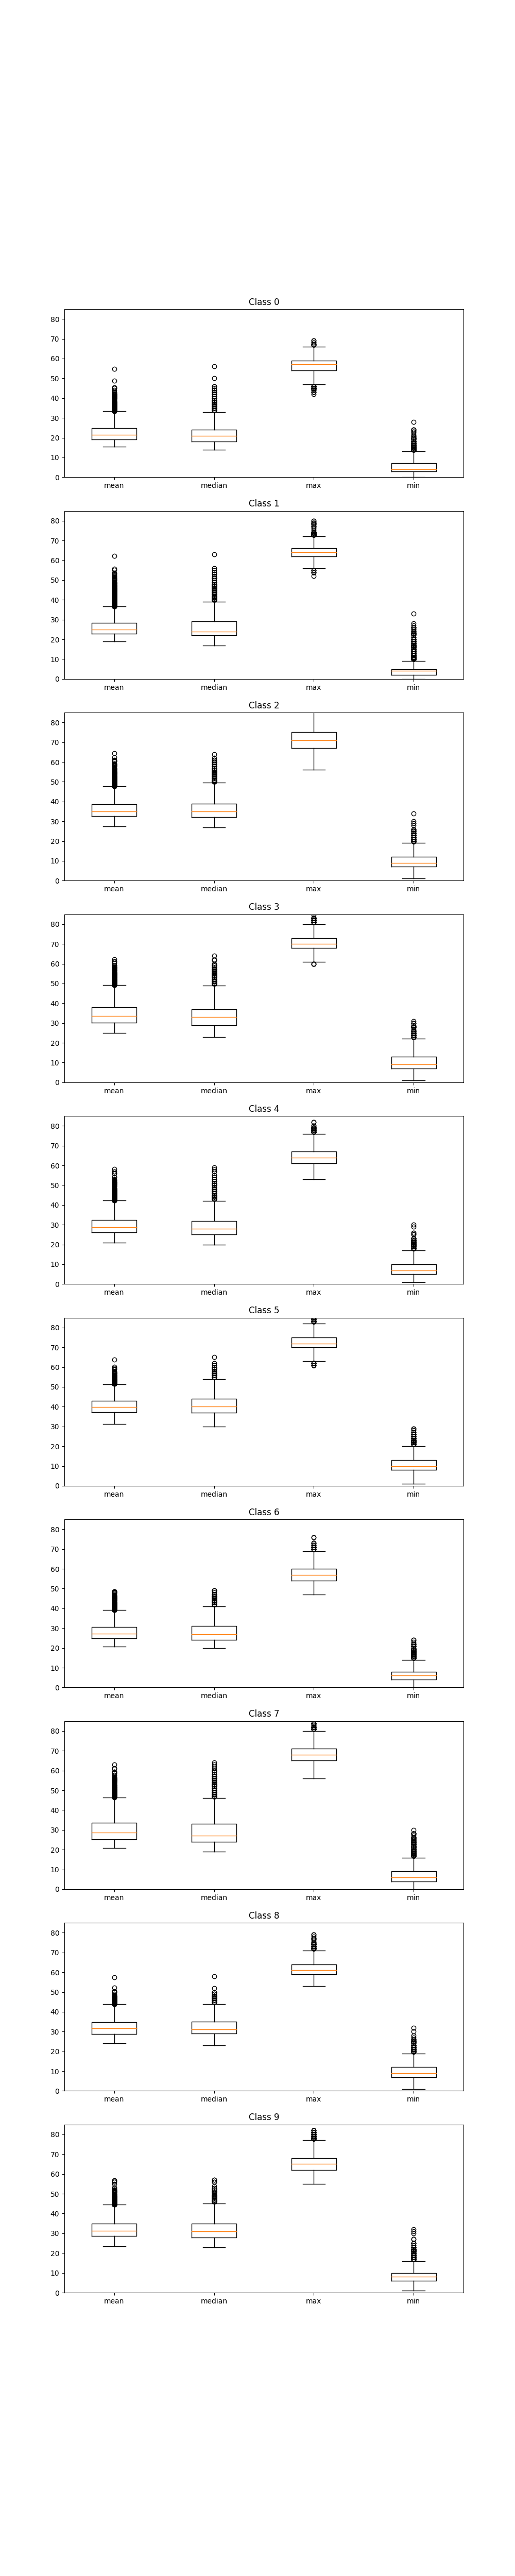

In [7]:
# Plot box and whiskers
fig = plt.figure(figsize=(10, 50))
for i in range(10):
    ax = plt.subplot(10, 1, i+1)
    distances = scipy.spatial.distance.squareform((scipy.spatial.distance.pdist(binaryFeatures[targets.ravel() == i, :], metric='hamming')*128).astype(np.uint8))
    indices = np.eye(distances.shape[0], dtype=bool)
    
    means = np.mean(distances, axis=0)
    medians = np.median(distances, axis=0)
    maxs = np.amax(distances, axis=0)
    distances[indices] = 129
    mins = np.amin(distances, axis=0)
    ax.boxplot([means, medians, maxs, mins])
    ax.set_xticklabels(['mean', 'median', 'max', 'min'])
    ax.set_title('Class {}'.format(i))
    ax.set_ylim([0, 85])

In [41]:
npzfile = np.load('binaryFeatures.npz')

binaryFeatures = npzfile['binaryFeatures']
targets = npzfile['targets']

npzfile = np.load('parameters.npz')

A1 = npzfile['A1']
b1 = npzfile['b1']
A2 = npzfile['A2']
b2 = npzfile['b2']

In [50]:
print(binaryFeatures.shape)
print(A1.shape)
print(A2.shape)

wVecs = np.zeros((0, 784))
for i in range(binaryFeatures.shape[0]):
    wVecs = np.vstack((wVecs, np.matmul(A2[:, binaryFeatures[i].ravel()], A1[binaryFeatures[i].ravel(), :])))
print(wVecs.shape)

# fig = plt.figure(figsize=(10, 50))
# for i in range(10):
#     ax = plt.subplot(10, 1, i+1)
#     distances = scipy.spatial.distance.squareform((scipy.spatial.distance.pdist(binaryFeatures[targets.ravel() == i, :], metric='hamming')*128).astype(np.uint8))
#     indices = np.eye(distances.shape[0], dtype=bool)




(60000, 128)
(128, 784)
(1, 128)


KeyboardInterrupt: 

In [53]:
np.savez('wVecs', wVecs=wVecs, targets=targets)

In [20]:
npzfile = np.load('wVecs.npz')

wVecs = npzfile['wVecs']
targets = npzfile['targets']

In [63]:
from sklearn.decomposition import PCA

In [59]:
print(targets.shape)

(60000, 1)


<IPython.core.display.Javascript object>


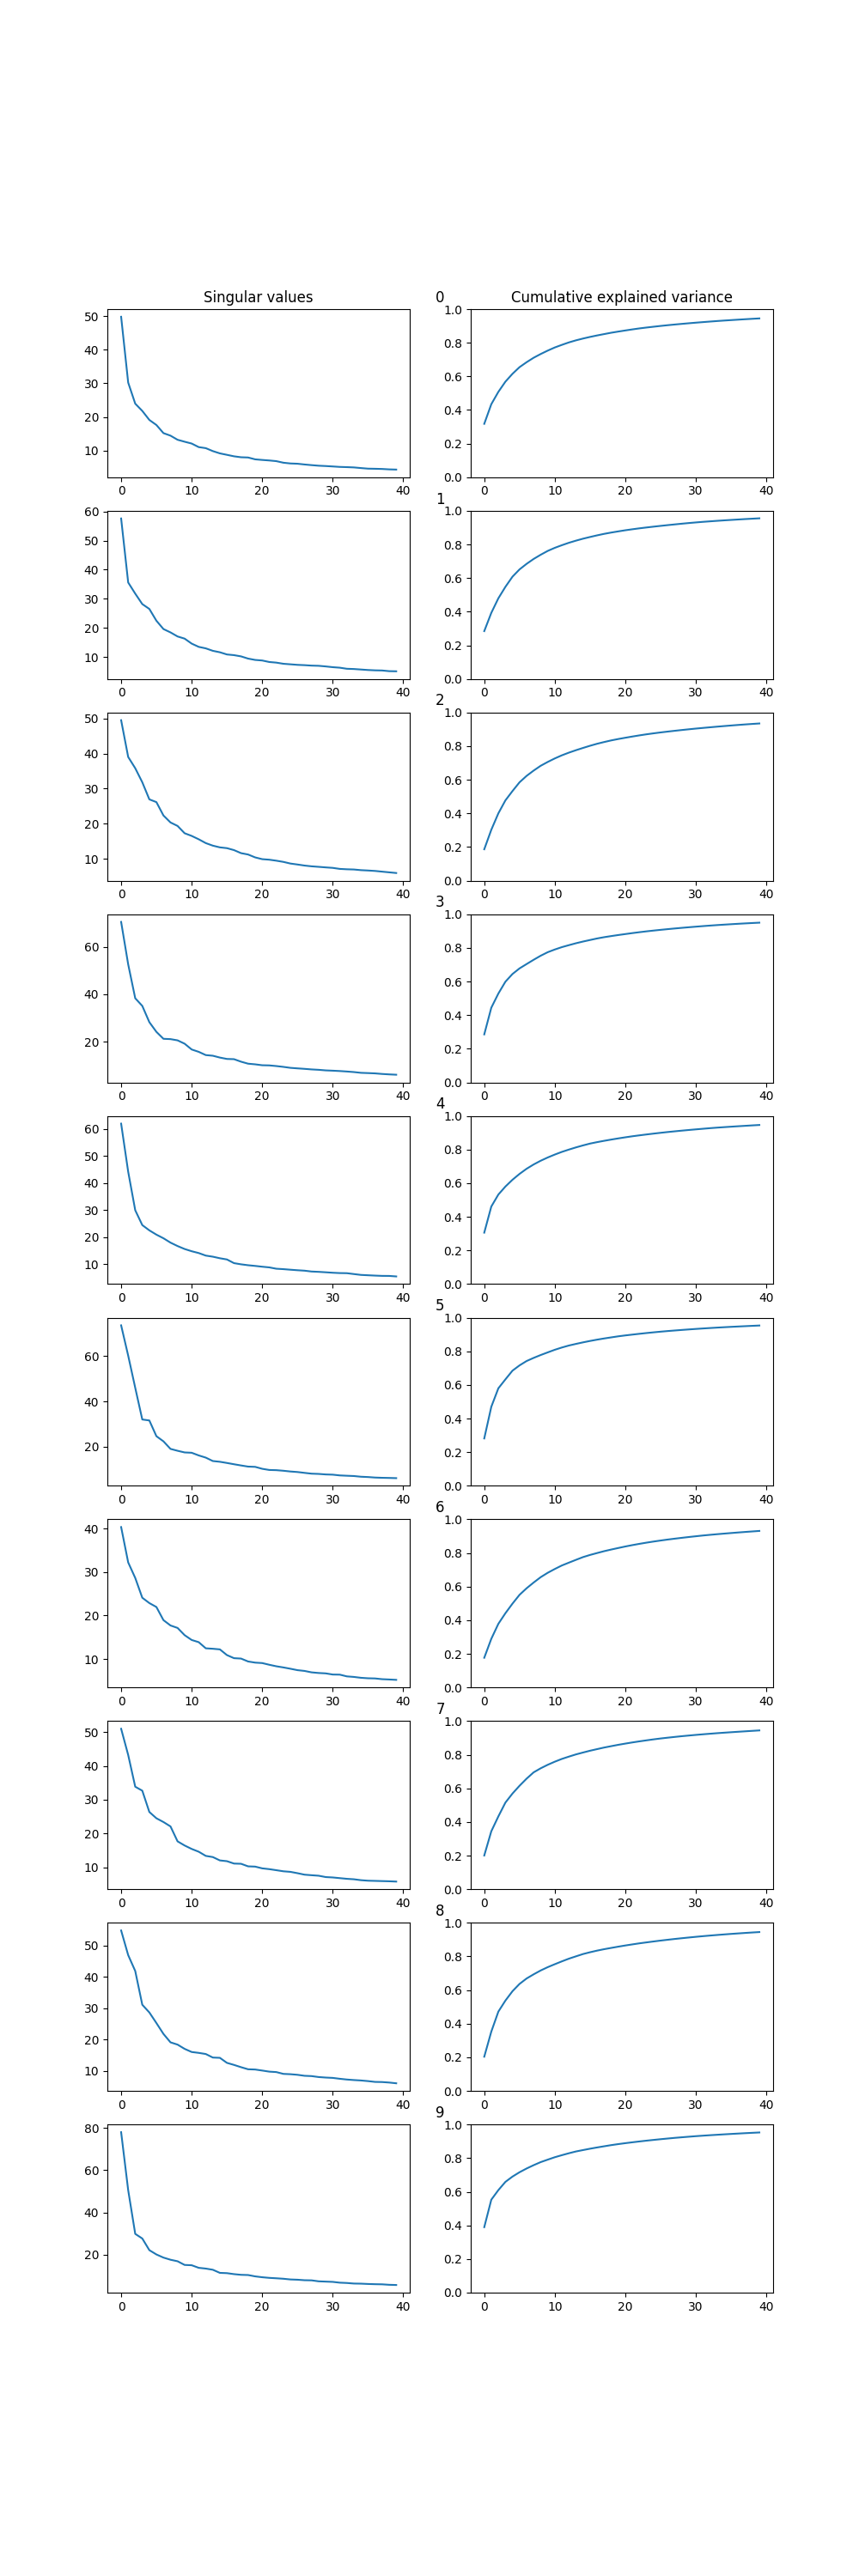

In [81]:
# PCA
fig = plt.figure(figsize=(10, 30))

axFull = fig.add_subplot(1, 2, 1)
axFull.set_title('Singular values')
axFull.set_axis_off()
axFull = fig.add_subplot(1, 2, 2)
axFull.set_title('Cumulative explained variance')
axFull.set_axis_off()

for i in range(10):
    axFull = fig.add_subplot(10, 1, i+1)
    ax1 = fig.add_subplot(10, 2, 2*i + 1)
    ax2 = fig.add_subplot(10, 2, 2*i + 2)
    
    wVecsClass = wVecs[targets.ravel() == i, :]
    pika = PCA(n_components=40)
    pika.fit(wVecsClass)
    ax1.plot(pika.singular_values_)
    ax2.plot(np.cumsum(pika.explained_variance_ratio_))
    ax2.set_ylim([0, 1])
    axFull.set_title(i)
    axFull.set_axis_off()

<IPython.core.display.Javascript object>


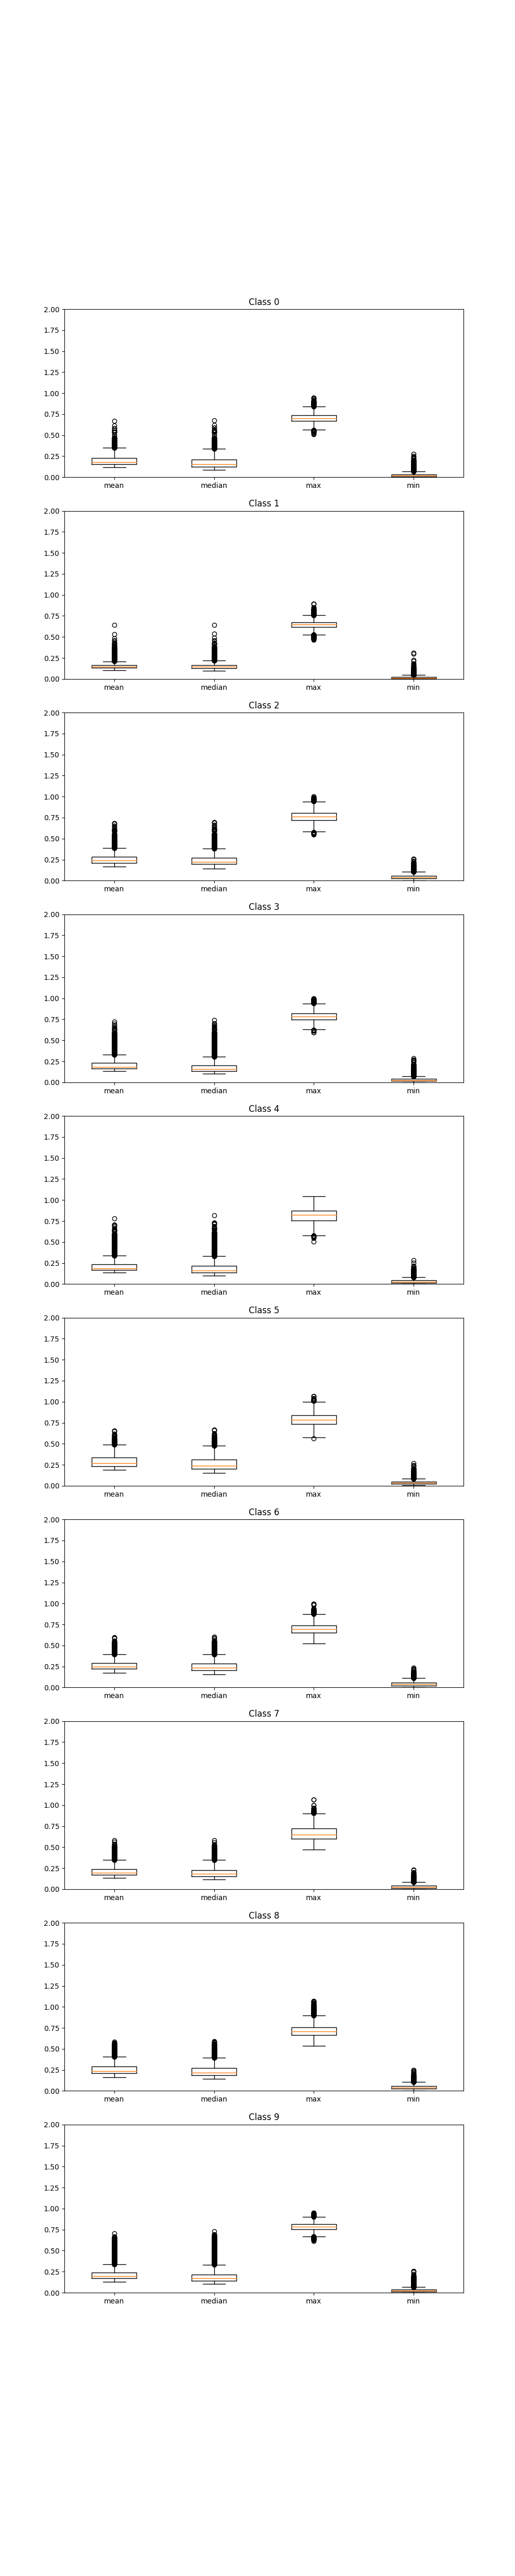

In [21]:
# Plot box and whisker plots
fig = plt.figure(figsize=(10, 50))
fig.tight_layout()

for i in range(10):
    ax = plt.subplot(10, 1, i+1)
    
    wVecsClass = wVecs[targets.ravel() == i, :]
    distances = scipy.spatial.distance.squareform((scipy.spatial.distance.pdist(wVecsClass, metric='cosine')))
    
    indices = np.eye(distances.shape[0], dtype=bool)
    means = np.mean(distances, axis=0)
    medians = np.median(distances, axis=0)
    maxs = np.amax(distances, axis=0)
    distances[indices] = 101
    mins = np.amin(distances, axis=0)
    
    #print("{}:\t mean: {}\t median: {}\t max: {}\t min: {}".format(i, np.mean(distances), np.median(distances), np.amax(distances), np.amin(distances[distances > 0])))
    
    ax.boxplot([means, medians, maxs, mins])
    ax.set_xticklabels(['mean', 'median', 'max', 'min'])
    ax.set_title('Class {}'.format(i))
    ax.set_ylim([0, 2])

<IPython.core.display.Javascript object>


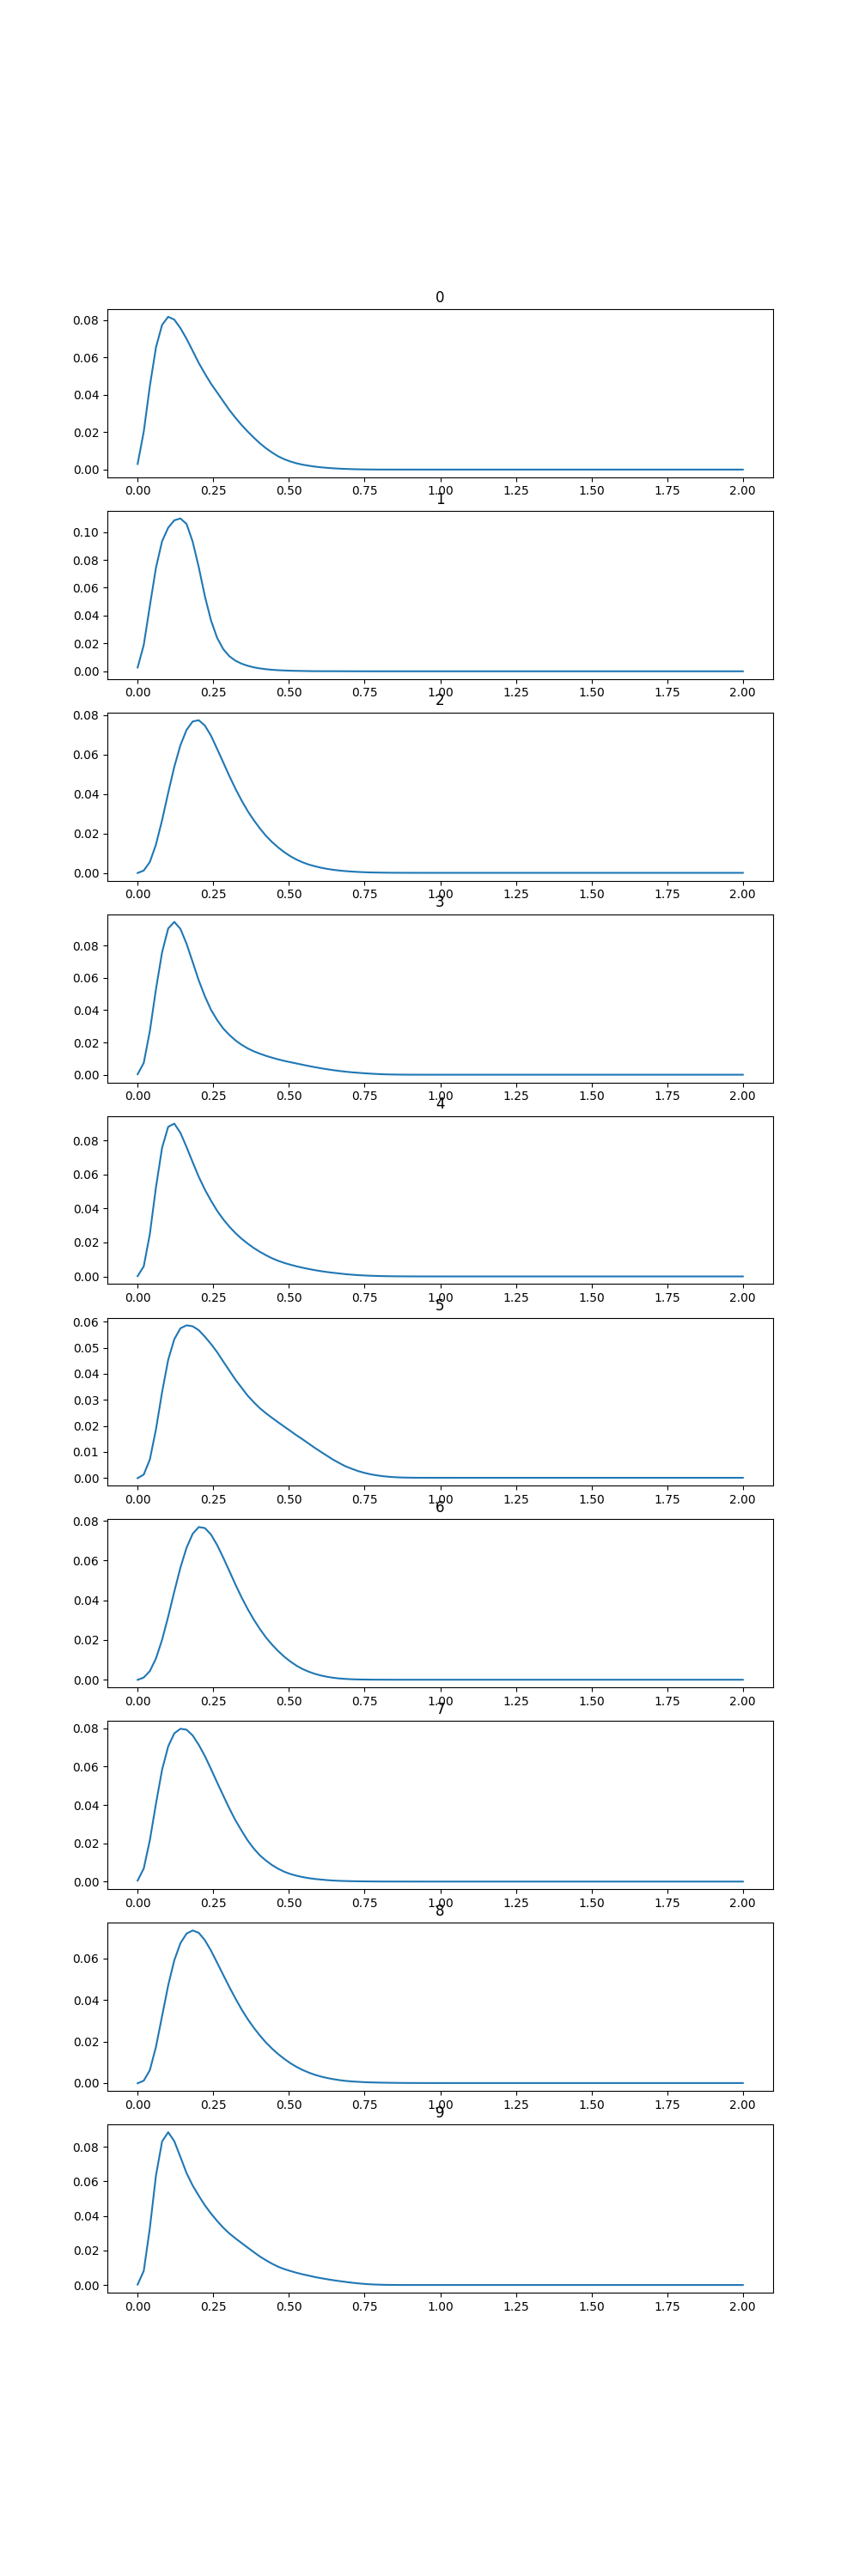

In [43]:
# Plot distributions
fig = plt.figure(figsize=(10, 30))
fig.tight_layout()

for i in range(10):
    axFull = fig.add_subplot(10, 1, i+1)
    
    wVecsClass = wVecs[targets.ravel() == i, :]
    distances = scipy.spatial.distance.squareform((scipy.spatial.distance.pdist(wVecsClass, metric='cosine')))
    
    dists = []
    for j in range(100):
        if j == 0:
            dists.append((np.sum(np.logical_and(j*(2/100) < distances, distances < (j+1)*(2/100))) - distances.shape[0])//2)
        else:
            dists.append(np.sum(np.logical_and(j*(2/100) < distances, distances < (j+1)*(2/100)))//2)
    
    axFull.plot(np.linspace(0, 2, 100), dists/sum(dists))
    axFull.set_title('{}'.format(i))